# Methada 2020: VESPUCCI exercise n° 2

In this second excercise we will use a different normalization technique, the TPM (Transcript Per Million) and show how it is easy to perform analysis outside the VESPUCCI toolbox. We will collect samples from leaf and fruit and fit a Gaussian Mixture Model to both the log-TPM distribution in order to estimate an expression cut-off. Then we will look for genes uniquely expressed in one tissue (fruit) based on the chosen cut-off.

In [1]:
%%html

<script src="https://cdn.plot.ly/plotly-latest.min.js"></script>

#### Import packages

In [2]:
from pycompass import Connect, Compendium, Module, Platform, Experiment, BiologicalFeature, SampleSet, Sample, Plot, Annotation
from IPython.core.display import display, HTML
import pandas as pd

#### Create a Connnect object and pass it the URL to point it to the COMPASS GraphQL endpoint

In [3]:
url = 'http://methada2020.uv.es:5555/graphql'
conn = Connect(url)

#### Since COMPASS is our interface to (possibily) many compendium, we'll list all of them and select the one we are interested in, i.e. VITIS_VINIFERA

In [4]:
vv_compendium = None
for compendium in conn.get_compendia():
    if compendium.compendium_name == 'vitis_vinifera':
        vv_compendium = compendium
        break

In [5]:
print(vv_compendium.description)

The Vitis vinifera gene expression compendium


#### Let's get all samples that has been annotated using the term PO_0025034 (LEAF)

In [6]:
leaf_samples = Sample.using(vv_compendium).get(filter={'annotationOntologyId': 'PO_0025034'})

#### Show the annotation in triples for the first sample just to show that it is actually a leaf sample

In [7]:
Annotation(leaf_samples[0]).get_triples()

[['PO_0025034', 'name', 'leaf'],
 ['GSM671719.ch1', 'type', 'PO_0025034'],
 ['NCBITaxon_29760', 'name', 'Vitis vinifera'],
 ['GSM671719.ch1', 'Genotype', 'NCBITaxon_29760'],
 ['GSM671719.ch1', 'cultivar', 'Touriga Nacional'],
 ['GSM671719.ch1', 'Year of Onset', 'N29a5371664a4424fabf28cf574b3931d'],
 ['N29a5371664a4424fabf28cf574b3931d', 'value', '2010'],
 ['UO_0000036', 'name', 'year'],
 ['N29a5371664a4424fabf28cf574b3931d', 'unit', 'UO_0000036'],
 ['GSM671719.ch1', 'is grown in', 'N97c704f479a442fa8ff1a429ee6b122b'],
 ['N97c704f479a442fa8ff1a429ee6b122b', 'Description', 'Growth chamber'],
 ['NCIT_C69074', 'name', 'Room'],
 ['N97c704f479a442fa8ff1a429ee6b122b', 'type', 'NCIT_C69074']]

#### Let's do the same with fruit samples (PO_0009001)

In [8]:
fruit_samples = Sample.using(vv_compendium).get(filter={'annotationOntologyId': 'PO_0009001'})

In [9]:
Annotation(fruit_samples[0]).get_triples()

[['GSM786240.ch1', 'whole plant development stage', '33'],
 ['GSM786240.ch1', 'Year of Onset', 'Nf07fe4a4ee774672a3c2c43dab7fe85d'],
 ['Nf07fe4a4ee774672a3c2c43dab7fe85d', 'value', '2003'],
 ['UO_0000036', 'name', 'year'],
 ['Nf07fe4a4ee774672a3c2c43dab7fe85d', 'unit', 'UO_0000036'],
 ['GSM786240.ch1', 'cultivar', 'Pinot Noir'],
 ['NCBITaxon_29760', 'name', 'Vitis vinifera'],
 ['GSM786240.ch1', 'Genotype', 'NCBITaxon_29760'],
 ['PO_0009001', 'name', 'fruit'],
 ['GSM786240.ch1', 'type', 'PO_0009001'],
 ['GSM786240.ch1', 'is grown in', 'N89fc0849700349e188237110d7878079'],
 ['N89fc0849700349e188237110d7878079',
  'http://purl.obolibrary.org/obo/GAZ_00000448',
  'N39ecd5ee6ef34438b059ab36095ee5ec'],
 ['N89fc0849700349e188237110d7878079', 'type', 'ENVO_00000116'],
 ['N39ecd5ee6ef34438b059ab36095ee5ec',
  'Description',
  "Ai molini San Michele all'Adige Italy"],
 ['N39ecd5ee6ef34438b059ab36095ee5ec',
  'Longitude',
  'N743ea0172ea146c592a56e9c196e5a20'],
 ['N39ecd5ee6ef34438b059ab36095ee5e

#### The compendium is a matrix of BiologicalFeature (genes) and SampleSet (conditions), thus we need to retrieve the SampleSet objects that correspond to the selected samples (there will be one SampleSet object per sample)

In [10]:
ss_leaf = SampleSet.using(vv_compendium).by(samples=leaf_samples, normalization='tpm_sample')

#### Cheeck that the normalization is the correct one (TPM per sample) and look at the design property to show that there's one sample per SampleSet object

In [11]:
print(ss_leaf[0].design)
print()
print(ss_leaf[0].normalization)

{'elements': {'nodes': [{'data': {'id': 'sample_1346', 'name': 'sample_1346', 'type': 'condition'}, 'position': {'x': 250, 'y': 100}}, {'data': {'id': 1346, 'name': 'GSM926669.ch1', 'type': 'sample', 'parent': 'sample_1346', 'position': {'x': 250, 'y': 100}}}]}}

tpm_sample


#### Let's do the same for fruit samples

In [12]:
ss_fruit = SampleSet.using(vv_compendium).by(samples=fruit_samples, normalization='tpm_sample')

#### We want the TPM values on specific samples for ALL gene, so just take them all

In [13]:
all_genes = BiologicalFeature.using(vv_compendium).get()

In [14]:
len(all_genes)

29090

#### Since the module creation process might take few moments we will read it from files I previously prepared. I commented the code used to create the module and save it to a local file.

In [15]:
#leaf_module = Module.using(vv_compendium).create(biofeatures=all_genes, samplesets=ss_leaf)
#leaf_module.write_to_file('leaf_module.vsp')
leaf_module = Module.read_from_file('leaf_module.vsp', conn)
#fruit_module = Module.using(vv_compendium).create(biofeatures=all_genes, samplesets=ss_fruit)
#fruit_module.write_to_file('fruit_module.vsp')
fruit_module = Module.read_from_file('fruit_module.vsp', conn)

#### Let's check the number of rows and columns 

In [16]:
leaf_module.values.shape

(29090, 265)

In [17]:
fruit_module.values.shape

(29090, 229)

#### Let's create a DataFrame from the LEAF module

In [18]:
df_leaf = pd.DataFrame(leaf_module.values)

In [19]:
df_leaf.head()

,0,1,2,3,4,5,6,7,8,9,...,255,256,257,258,259,260,261,262,263,264
0,2.764811,1.028238,4.206524,4.310490,3.380724,5.182375,5.234440,1.706860,NaN,0.897714,...,NaN,NaN,0.505667,1.067448,NaN,NaN,NaN,NaN,NaN,NaN
1,7.977974,20.451429,7.393938,10.357115,11.087131,6.088290,9.424425,1.464318,2.149159,0.945798,...,4.206650,5.950305,2.568625,2.831642,3.806943,13.235563,4.392203,3.001801,8.769095,4.734651
2,3.153186,7.160503,5.426817,4.758333,4.803992,5.468077,6.968742,3.877357,4.576341,3.900253,...,2.929758,2.652722,2.448025,2.086960,0.409856,0.344589,0.324705,0.535296,0.521250,0.079692
3,0.666377,0.044058,0.128744,NaN,0.438385,0.020561,NaN,1.828394,0.370812,0.512872,...,0.266130,0.305222,1.029177,0.114345,0.084211,0.566405,0.537057,0.102652,0.249896,0.114617
4,10.299772,3.211150,16.118332,28.548820,12.532623,17.031933,16.852312,2.751205,5.463408,5.375938,...,22.594732,11.003358,14.136192,11.649676,16.070078,16.046747,19.964981,8.467222,10.693089,13.096622


#### Let's import all the packages we need to plot distributions and fit a Gaussian Mixture Model

In [20]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.mixture import GaussianMixture
from scipy.stats import norm

%matplotlib inline
sns.set(color_codes=True)


#### We will use all the values as a single array (insted of a matrix) and remove zeros and NaNs prior to log2-transformation

In [21]:
leaf_all_values = df_leaf.values.flatten()
leaf_all_values[leaf_all_values == 0] = np.nan
leaf_all_values = leaf_all_values[~np.isnan(leaf_all_values)]
leaf_all_values = np.log2(leaf_all_values)

#### Now we are ready to plot the distribution of the leaf (log2)TPM values

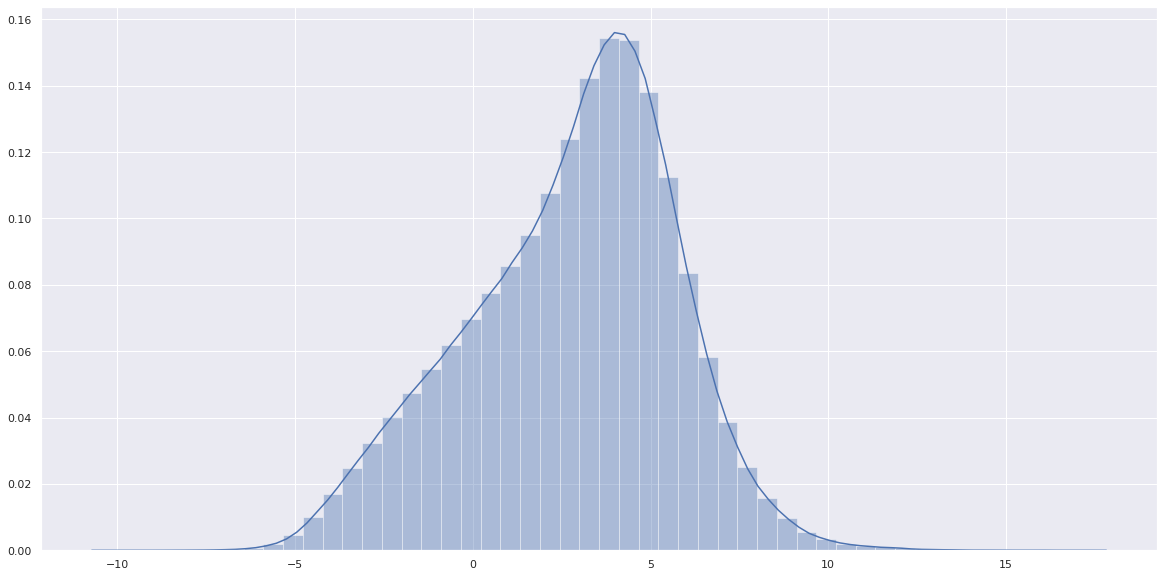

In [22]:
plt.figure(figsize=(20,10))

ax = sns.distplot(leaf_all_values)

#### The idea to fit a 2-component Gaussian Mixture Model comes from the paper: **Hebenstreit, D., Fang, M., Gu, M., Charoensawan, V., van Oudenaarden, A., & Teichmann, S. A. (2011).** *RNA sequencing reveals two major classes of gene expression levels in metazoan cells.* Molecular systems biology, 7(1).

https://www.embopress.org/doi/full/10.1038/msb.2011.28

#### Let's fit the 2 component Mixture Model and calculate values to plot the distributions

In [23]:
gmm = GaussianMixture(n_components=2)
gmm.fit(leaf_all_values.reshape(-1, 1))

x = np.linspace(-15, 15, 1000)

y1 = norm.pdf(x, gmm.means_[0][0], np.sqrt(gmm.covariances_[0][0])) * gmm.weights_[0]
y2 = norm.pdf(x, gmm.means_[1][0], np.sqrt(gmm.covariances_[1][0])) * gmm.weights_[1]

#### These are the two components, the Low Expressed genes and High Expressed genes

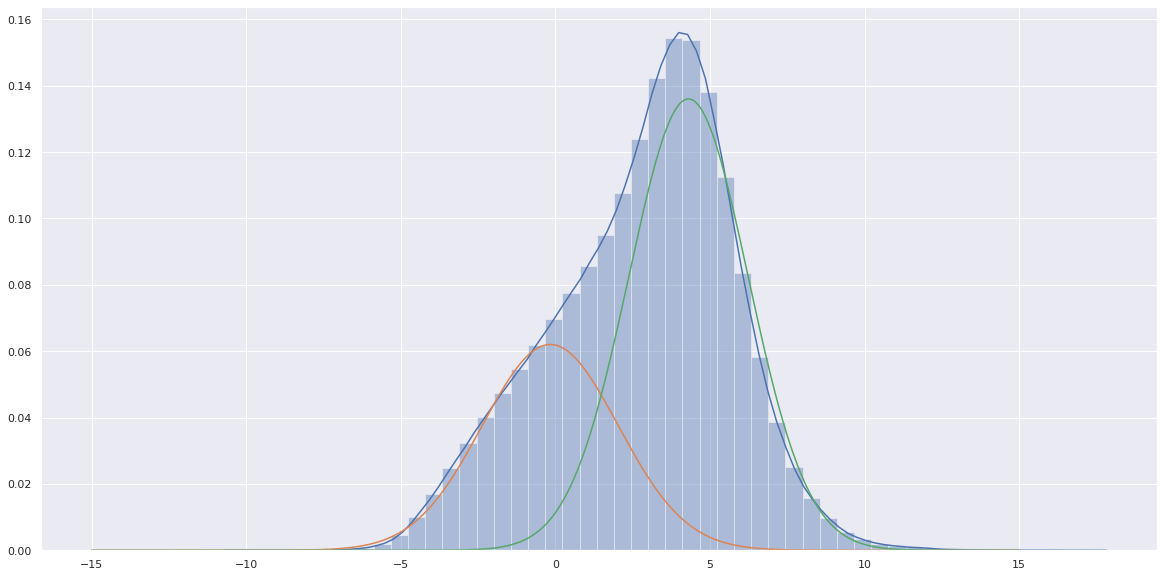

In [24]:
plt.figure(figsize=(20,10))

ax = sns.distplot(leaf_all_values)
ax.plot(x, y1)
ax.plot(x, y2)
plt.show()

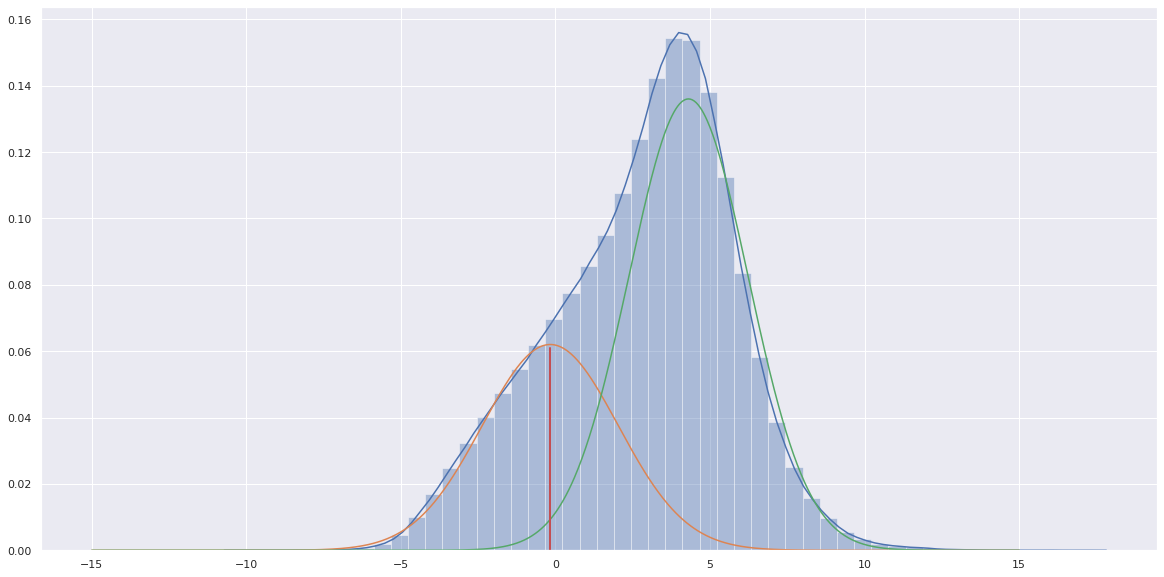

In [25]:
plt.figure(figsize=(20,10))

ax = sns.distplot(leaf_all_values)
ax.plot(x, y1)
ax.plot(x, y2)
mean = min(*gmm.means_)
ax.plot([mean, mean], [0, 0.061], lw=2)
plt.show()

#### This is the first threshold

In [26]:
mean**2

array([0.02871348])

#### Let's do the same for the fruit model

In [27]:
df_fruit = pd.DataFrame(fruit_module.values)
fruit_all_values = df_fruit.values.flatten()
fruit_all_values[fruit_all_values == 0] = np.nan
fruit_all_values = fruit_all_values[~np.isnan(fruit_all_values)]
fruit_all_values = np.log2(fruit_all_values)

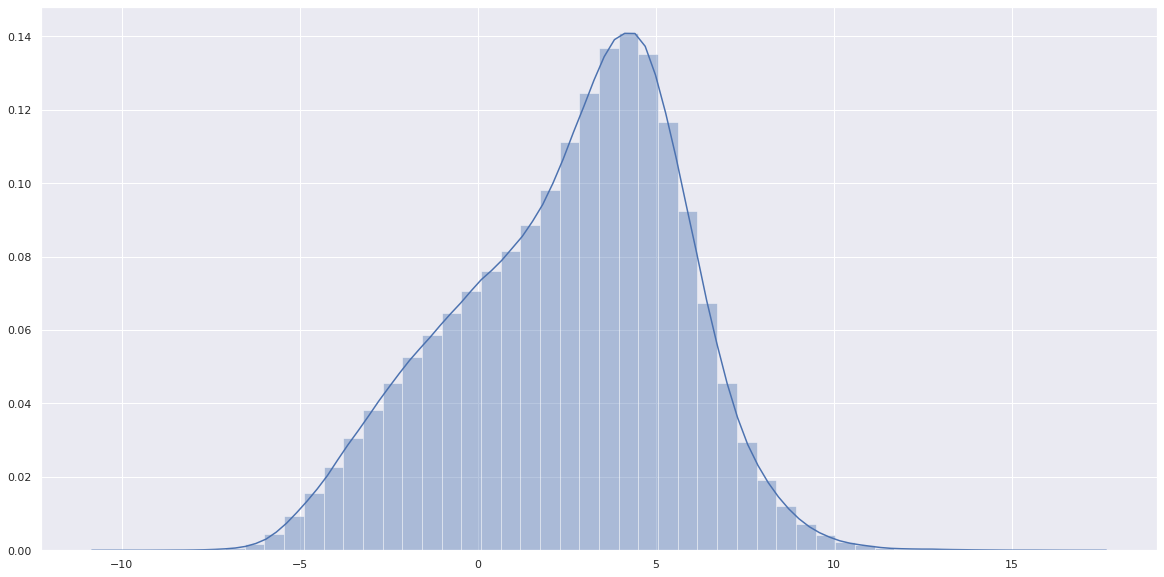

In [28]:
plt.figure(figsize=(20,10))

ax = sns.distplot(fruit_all_values)

In [29]:
gmm = GaussianMixture(n_components=2)
gmm.fit(fruit_all_values.reshape(-1, 1))

x = np.linspace(-15, 15, 1000)

y1 = norm.pdf(x, gmm.means_[0][0], np.sqrt(gmm.covariances_[0][0])) * gmm.weights_[0]
y2 = norm.pdf(x, gmm.means_[1][0], np.sqrt(gmm.covariances_[1][0])) * gmm.weights_[1]

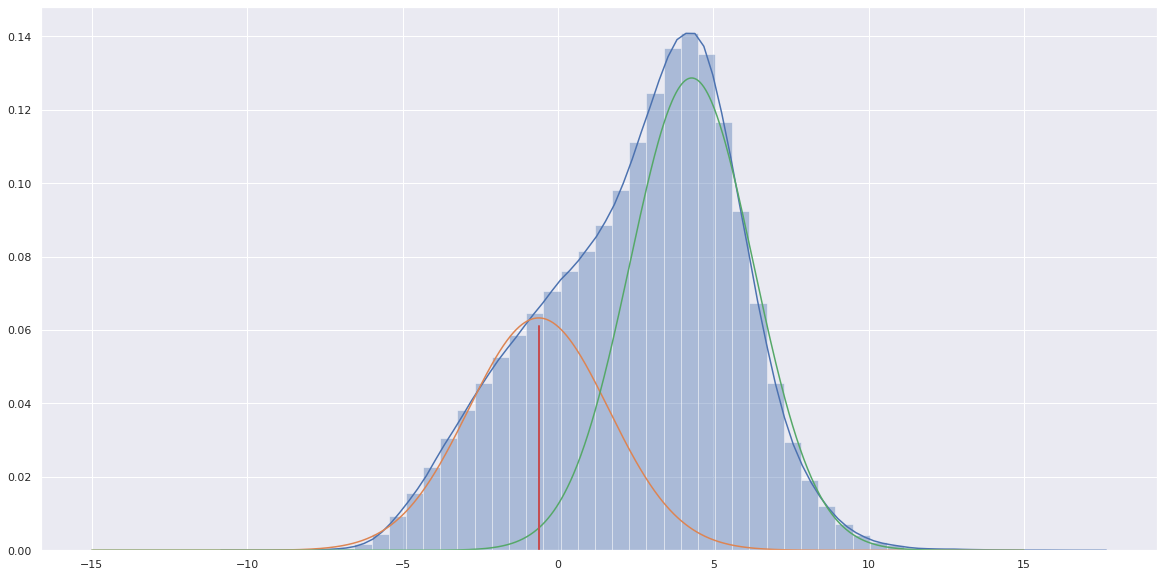

In [30]:
plt.figure(figsize=(20,10))

ax = sns.distplot(fruit_all_values)
ax.plot(x, y1)
ax.plot(x, y2)
mean = min(*gmm.means_)
ax.plot([mean, mean], [0, 0.061], lw=2)
plt.show()

#### This is the second threshold

In [31]:
mean**2

array([0.38182439])

#### Now we are ready to select only genes that pass the thresholds and call them 'expressed', the other will be 'not expressed'

In [32]:
expressed = df_leaf.mean(axis=1) >= 0.020
leaf_expressed = df_leaf.index[expressed].to_list()
leaf_not_expressed = df_leaf.index[~expressed].to_list()

In [33]:
expressed = df_fruit.mean(axis=1) >= 0.34
fruit_expressed = df_fruit.index[expressed].to_list()
fruit_not_expressed = df_fruit.index[~expressed].to_list()

#### These are the numbers for expressed and not expressed gene in leaf and fruit

In [34]:
len(leaf_expressed), len(leaf_not_expressed), len(fruit_expressed), len(fruit_not_expressed)

(28484, 606, 25277, 3813)

#### Now we define and genes uniquely expressed in fruit as the intersection of genes expressed in fruit and not expressed in leaf

In [35]:
unique_fruit = set.intersection(set(fruit_expressed), set(leaf_not_expressed))

#### Let's get the gene names (we just worked with ids so far), and print the first 10

In [36]:
unique_fruit_names = [fruit_module.biological_features[i].name for i in unique_fruit]

In [37]:
unique_fruit_names[:10]

['VIT_18s0041g01020',
 'VIT_04s0023g02890',
 'VIT_03s0132g00330',
 'VIT_16s0013g00460',
 'VIT_14s0006g02180',
 'VIT_19s0027g00850',
 'VIT_16s0050g02380',
 'VIT_01s0010g01560',
 'VIT_01s0010g01580',
 'VIT_12s0028g03000']

In [38]:
html_annotation_gene = Annotation(BiologicalFeature.using(vv_compendium).get(filter={'name': 'VIT_16s0050g02380'})[0]).plot_network()

In [40]:
display(HTML(html_annotation_gene))